# $10^{th}$ exercises
## Notebook setup
#### Used libraries

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#### Functions

In [6]:
#Load and print config files
def LoadConf(path,T=int):
    d={}
    with open(path) as file:
        for line in file:
            (directive,key, val) = line.split()
            if(directive=="#define"): d[key] = T(val)
    return d

def PrintConf(d):
    for key, val in d.items(): print("{0:<19}{1}".format(key,val))
        
#Plot shortcuts
def PlotSetup():
    plt.axes().set_facecolor(bg1)
    plt.grid(alpha=0.3)

def MultiplotSetup(fig,r,c):
    for i in range(r*c):
        plt.subplot(r,c,i+1)
        fig.axes[i].set_facecolor(bg1)
        plt.grid(alpha=0.3) 
    
def Legend():
    leg = plt.legend(facecolor=bg2)
    for text in leg.get_texts():
        text.set_color(el1)
        
def Errbar1Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.plot(x,y,color=el1)
    
def Errbar2Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.vlines(x,y-2*e,y+2*e,color=er2,alpha=0.4, label="$2\sigma$")
    plt.plot(x,y,color=el1)

#### Colors

In [5]:
#background
bg1 = "#191724" 
bg2 = "#26233a" 
#elements
el1 = "#e0def4" 
el2 = "#f6c177" 
el3 = "#eb6f92" 
#errorbars
er1 = "#908caa"  
er2 = "#6e6a86"

## 10.1 - Parallel computing
### Introductory notes

Beside being a valuable tool for optimization, parallel computing allows for more performant genetic algorithm searches. The first and basic application is that of running the same code on different nodes at the same time starting from different random seeds, in order to gain the possibility to comapre different solutions - which could be of great advantage since genetic algorithms are sort of black-boxes. But we can go further than that and take advantage of the parallel execution of the code to make operations not only at individual-level but also at population-level. In fact, we could make the populations evolve indipendently on each node and then, after a certain amount of steps, let the nodes exchange the best individual of each population (a sort of migration, to keep on with the biological metaphor).

### Excercise goal
**Goal:** Solve the TSP for the 50 US capitals using genetic alghorithms and parallel computing. We will compare the results obtained for:
- a non parallel code
- a parallel code without migration
- a parallel code with migration

### Implementation notes
We've implemented an awk script in order to omogenize input data (for example, space was used as separator but some cities had spaces in their name).

*Each excercise is a completion of the previous so in the following we wont distinguish between excercises: everything we will talk about will surely be found in 10.3.*

To parallelize our algorithm we have to deal with two problems: 
1. finding the node with the best solution and tell it to print its results;
2. implementing random migration.

In order to solve the first problem we use the MPI function  `MPI_Allreduce` together with `MPI_MINLOC`: this is a global blocking function that collects inputs from all nodes and gives to all nodes the minimum value and the node that owns it as output. Thanks to that we are able to compare the costs of the best indiviual of each node and write an output instruction specific for the node that found the best solution.

The second problem is a bit more tough. To solve it we decided to use `MPI_Scatter`, that is a global blocking function that takes as input an array from one node and gives as output the i-th element of the array to the i-th node. We create a vector of lenght N_NODES whith elements $0\dots$N_NODES-1 (we can almost directly use this vector with the mpi function, since its underlying array can be accessed thanks to the method `data()`). After schuffling the vector contains the following information: the i-th node should send its best individual to the node labelled by the i-th element of the vector. Starting from here we create another vector to tell each node who is sending them the individual. We tehn use two `MPI_Scatter` to tell each node who they are sending-to and receiving-from. Now we can use `MPI_Isend` and `MPI-Ireceive` to exchange the chromosome (that is: exchanging the underlying array). We must use non-blocking instruction in order to avoid the headaches of cooridinating each exchange. To avoid the risk that a chromosome is overwritten before being sent, on arrival new chromosomes are stored in a temporary array. We set an `MPI_Barrier` to be sure that all nodes waits for the communication to end before going further. Only after everyone has sent and received their chromosome each node can store them in the population and go on independetly till next migration.

## Results

Parallel computing is done with 5 nodes. 

The results shown are based on the following parameters for the execution of the algorithm

In [4]:
conf_sim=LoadConf("in/10-conf_simulation.inl")
PrintConf(conf_sim)

N_GEN              300
INDIVIDUALS        100000


And on the following parameters for the genetic operations

In [8]:
conf_ga=LoadConf("in/10-conf_ga.inl",float)
PrintConf(conf_ga)

SELECTION          2.0
P_CROSSOVER        0.65
P_PERMELM          0.08
P_PERMINT          0.05
P_CYCLEINT         0.07
P_MIRRORINT        0.1
N_MIGRATION        15.0


Where `SELECTION` is the exponent of the selection operator, `P_CROSSOVER` is the crossover probability, `N_MIGRATION` is the number of generations between two successive migrations, and the others are the probabilities for each mutation:
- `P_PERMELM` =  excange of two elements
- `P_PERMINT` =  excange of two intervals
- `P_CYCLEINT` =  cycle elements in an interval
- `P_MIRRORINT` =  mirror elements in an interval

#### Single node

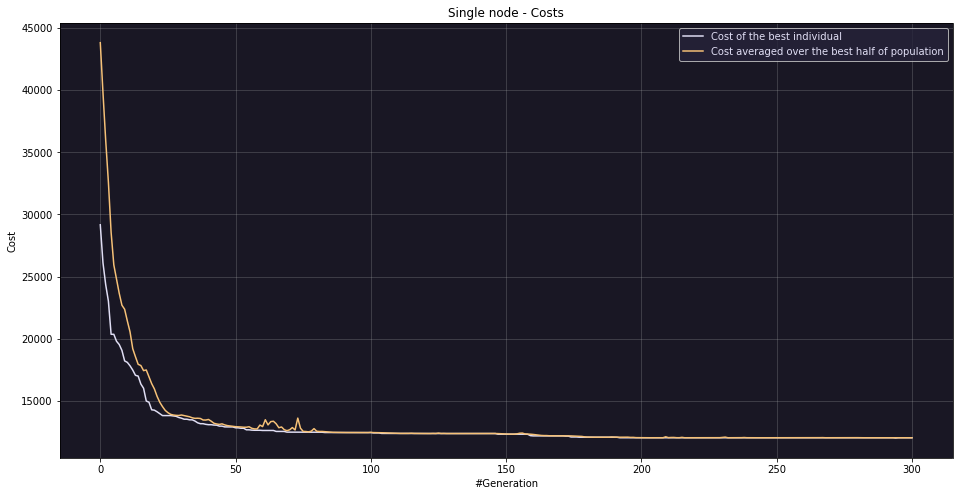

In [8]:
fig=plt.figure(figsize=(16, 8))

#Circle
plt.axes().set_facecolor(bg1)
##Best cost
data = np.genfromtxt("out/101-bestcost.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]
plt.plot(x,y,color=el1, label="Cost of the best individual")
##Ave cost
data = np.genfromtxt("out/101-besthalfcost.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]
plt.plot(x,y,color=el2, label="Cost averaged over the best half of population")

plt.xlabel('#Generation')
plt.ylabel('Cost')
plt.title("Single node - Costs")
plt.grid(alpha=0.3)
Legend()


plt.show()



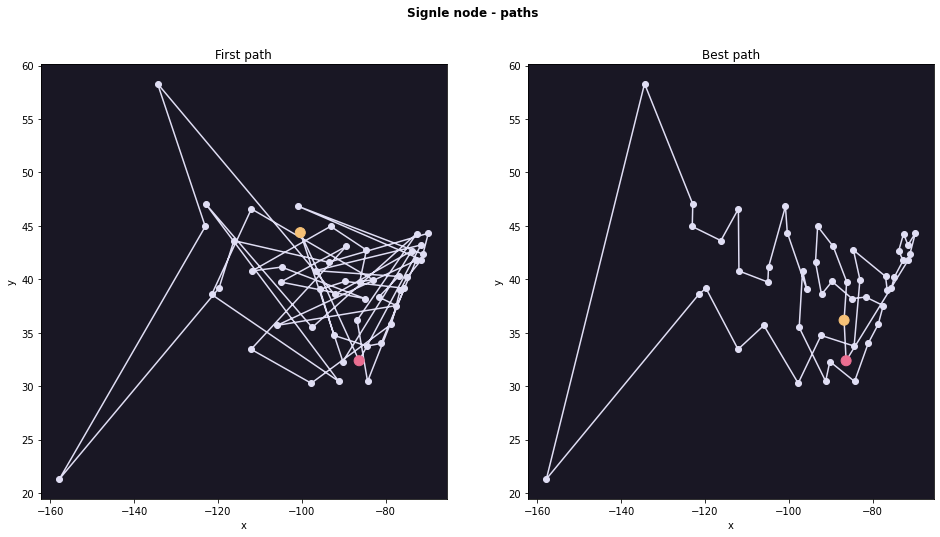

In [9]:
fig=plt.figure(figsize=(16, 8))
plt.suptitle('Signle node - paths', weight='bold')

plt.subplot(121)
fig.axes[0].set_facecolor(bg1)
data = np.genfromtxt("out/101-firstpath.csv", delimiter=",", skip_header=1)
x=np.append(data[:,0],data[0,0])
y=np.append(data[:,1],data[0,1])
plt.plot(x,y, label='test', c=el1, marker="o",zorder=-1)
plt.scatter(x[:2],y[:2], label='test', c=[el3,el2], marker="o",s=100)

plt.xlabel('x')
plt.ylabel('y')
plt.title('First path')


plt.subplot(122)
fig.axes[1].set_facecolor(bg1)
data = np.genfromtxt("out/101-bestpath.csv", delimiter=",", skip_header=1)
x=np.append(data[:,0],data[0,0])
y=np.append(data[:,1],data[0,1])
plt.plot(x,y, label='test', c=el1, marker="o",zorder=-1)
plt.scatter(x[:2],y[:2], label='test', c=[el3,el2], marker="o",s=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best path')
plt.show()

#### Indipendent parallel execution

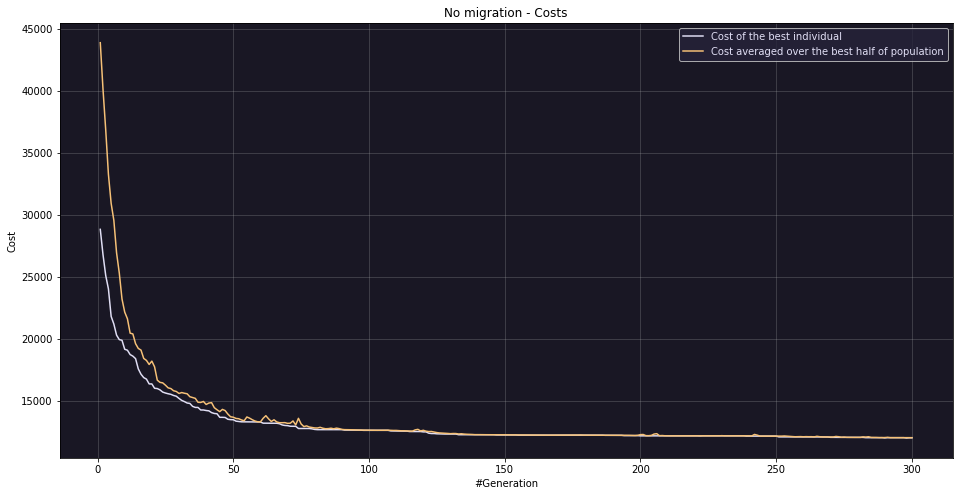

In [10]:
fig=plt.figure(figsize=(16, 8))

#Circle
plt.axes().set_facecolor(bg1)
##Best cost
data = np.genfromtxt("out/102-bestcost.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]
plt.plot(x,y,color=el1, label="Cost of the best individual")
##Ave cost
data = np.genfromtxt("out/102-besthalfcost.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]
plt.plot(x,y,color=el2,label="Cost averaged over the best half of population")

plt.xlabel('#Generation')
plt.ylabel('Cost')
plt.title("No migration - Costs")
plt.grid(alpha=0.3)
Legend()


plt.show()


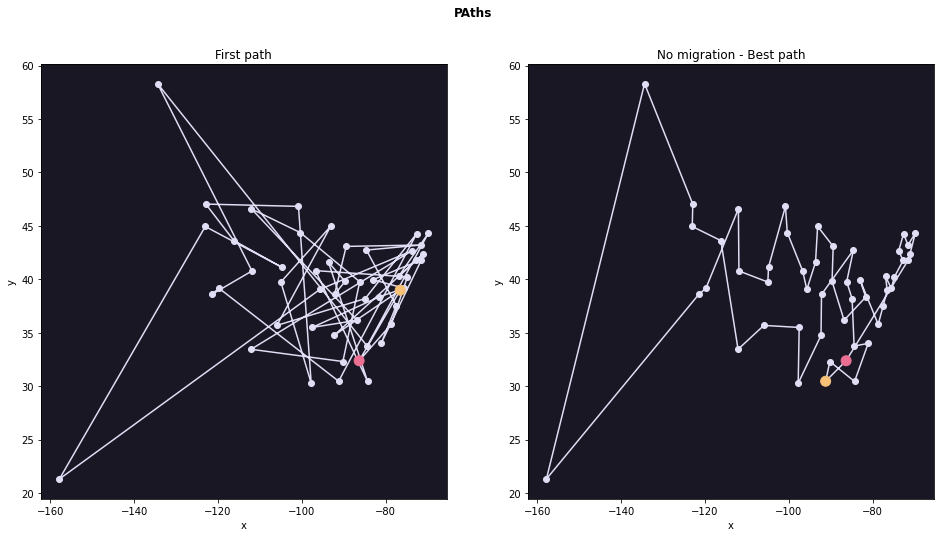

In [11]:
fig=plt.figure(figsize=(16, 8))
plt.suptitle('PAths', weight='bold')

plt.subplot(121)
fig.axes[0].set_facecolor(bg1)
data = np.genfromtxt("out/102-firstpath.csv", delimiter=",", skip_header=1)
x=np.append(data[:,0],data[0,0])
y=np.append(data[:,1],data[0,1])
plt.plot(x,y, label='test', c=el1, marker="o",zorder=-1)
plt.scatter(x[:2],y[:2], label='test', c=[el3,el2], marker="o",s=100)

plt.xlabel('x')
plt.ylabel('y')
plt.title('First path')


plt.subplot(122)
fig.axes[1].set_facecolor(bg1)
data = np.genfromtxt("out/102-bestpath.csv", delimiter=",", skip_header=1)
x=np.append(data[:,0],data[0,0])
y=np.append(data[:,1],data[0,1])
plt.plot(x,y, label='test', c=el1, marker="o",zorder=-1)
plt.scatter(x[:2],y[:2], label='test', c=[el3,el2], marker="o",s=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('No migration - Best path')
plt.show()

#### Parallel execution with migration

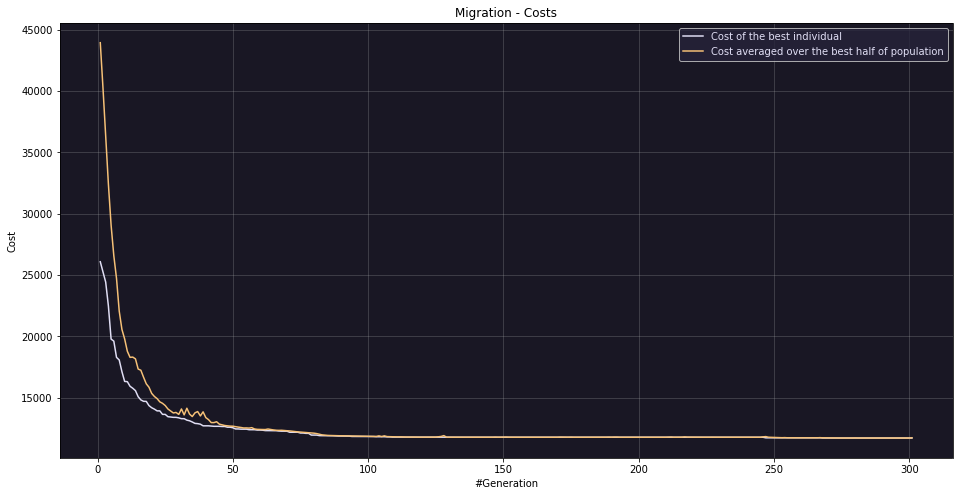

In [12]:
fig=plt.figure(figsize=(16, 8))

#Circle
plt.axes().set_facecolor(bg1)
##Best cost
data = np.genfromtxt("out/103-bestcost.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]
plt.plot(x,y,color=el1, label="Cost of the best individual")
##Ave cost
data = np.genfromtxt("out/103-besthalfcost.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]
plt.plot(x,y,color=el2,label="Cost averaged over the best half of population")

plt.xlabel('#Generation')
plt.ylabel('Cost')
plt.title("Migration - Costs")
plt.grid(alpha=0.3)
Legend()

plt.show()


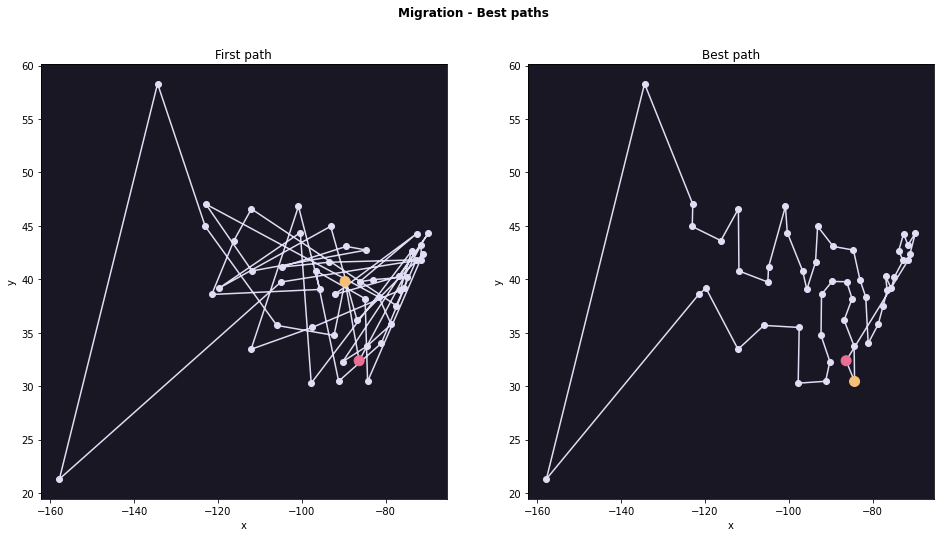

In [13]:
fig=plt.figure(figsize=(16, 8))
plt.suptitle('Migration - Best paths', weight='bold')

plt.subplot(121)
fig.axes[0].set_facecolor(bg1)
data = np.genfromtxt("out/103-firstpath.csv", delimiter=",", skip_header=1)
x=np.append(data[:,0],data[0,0])
y=np.append(data[:,1],data[0,1])
plt.plot(x,y, label='test', c=el1, marker="o",zorder=-1)
plt.scatter(x[:2],y[:2], label='test', c=[el3,el2], marker="o",s=100)

plt.xlabel('x')
plt.ylabel('y')
plt.title('First path')


plt.subplot(122)
fig.axes[1].set_facecolor(bg1)
data = np.genfromtxt("out/103-bestpath.csv", delimiter=",", skip_header=1)
x=np.append(data[:,0],data[0,0])
y=np.append(data[:,1],data[0,1])
plt.plot(x,y, label='test', c=el1, marker="o",zorder=-1)
plt.scatter(x[:2],y[:2], label='test', c=[el3,el2], marker="o",s=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best path')
plt.show()

In conclusion we present a comparison between the cost of the best individuals for each method.

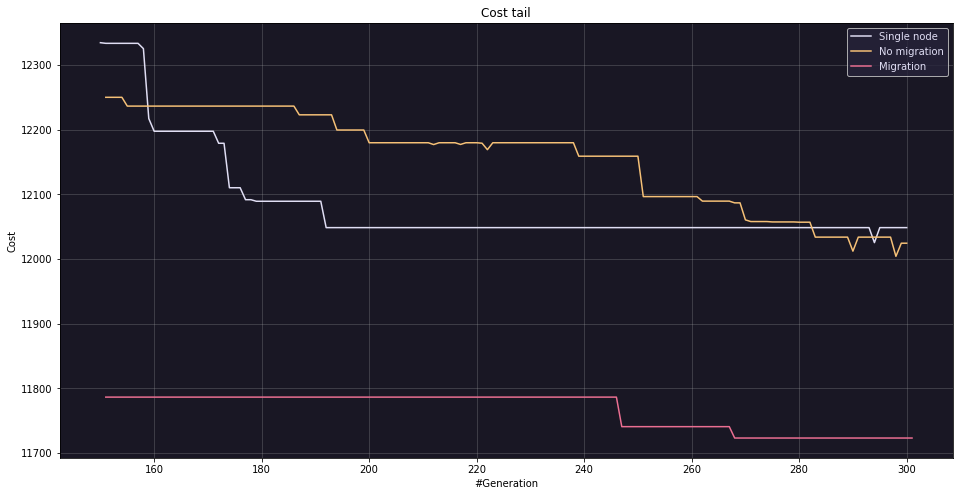

In [15]:
fig=plt.figure(figsize=(16, 8))

#Circle
plt.axes().set_facecolor(bg1)
##101
data = np.genfromtxt("out/101-bestcost.csv", delimiter=",", skip_header=1)
x=data[150:,0]
y=data[150:,1]
plt.plot(x,y,color=el1, label="Single node")
##102
data = np.genfromtxt("out/102-bestcost.csv", delimiter=",", skip_header=1)
x=data[150:,0]
y=data[150:,1]
plt.plot(x,y,color=el2, label="No migration")
##103
data = np.genfromtxt("out/103-bestcost.csv", delimiter=",", skip_header=1)
x=data[150:,0]
y=data[150:,1]
plt.plot(x,y,color=el3, label="Migration")

plt.xlabel('#Generation')
plt.ylabel('Cost')
plt.title("Cost tail")
plt.grid(alpha=0.3)
Legend()

plt.show()

As we can see indipendent parallel computation comports just a small improvement with respect to the basic version of the genetic algorithm. On the other hand introducing migration seems to improve the optimal solution found. This seems to be always the case (at least such has been for the values we tried) but if migration happens too often the advantage reduces.